#  Генерация текста с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


## Задачи для совместного разбора

1\. Рассмотрите основные шаги обучения модели для генерации текста с использованием RNN.

![text gen](https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png)

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
batch_size, seq_len = 16, 5
x = th.randint(0, 10, size=(batch_size, seq_len))
x.shape

torch.Size([16, 5])

In [ ]:
embedding_dim = 32
embedding = nn.Embedding(
    num_embeddings=10,
    embedding_dim=embedding_dim
)
x_e = embedding(x)
x_e.shape

torch.Size([16, 5, 32])

In [ ]:
embedding.weight.shape

torch.Size([10, 32])

In [ ]:
hidden_size = 15
rnn = nn.RNN(
    input_size=embedding_dim,
    hidden_size=hidden_size,
    batch_first=True,
)
out, h = rnn(x_e)
print(out.shape, h.shape)

torch.Size([16, 5, 15]) torch.Size([1, 16, 15])


In [ ]:
out[0]

torch.Size([5, 15])

In [ ]:
out[0][1]

tensor([-0.1368,  0.2714,  0.6290, -0.1286, -0.6385, -0.7978,  0.5825, -0.5952,
        -0.3692, -0.2634,  0.3295, -0.1316,  0.5934,  0.4368,  0.3552],
       grad_fn=<SelectBackward0>)

In [ ]:
x[:4]

tensor([[0, 3, 5, 3, 0],
        [1, 7, 7, 7, 5],
        [1, 3, 9, 3, 5],
        [5, 0, 7, 9, 7]])

In [ ]:
x[:, :-1][:4]

tensor([[0, 3, 5, 3],
        [1, 7, 7, 7],
        [1, 3, 9, 3],
        [5, 0, 7, 9]])

In [ ]:
x[:, 1:][:4]

tensor([[3, 5, 3, 0],
        [7, 7, 7, 5],
        [3, 9, 3, 5],
        [0, 7, 9, 7]])

In [ ]:
x_train = x[:, :-1]
x_train_e = embedding(x_train)
out, h = rnn(x_train_e)
out.shape

torch.Size([16, 4, 15])

In [ ]:
out_2d = out.reshape(16 * 4, 15)
out_2d.shape

torch.Size([64, 15])

In [ ]:
fc = nn.Linear(hidden_size, 10)
fc(out_2d).shape

torch.Size([64, 10])

## Задачи для самостоятельного решения

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<p class="task" id="1"></p>

### 1
Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`. Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/pets_ru_en.csv")
data.head()

,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en


In [ ]:
data['имя'] = data['имя'].str.lower()
data = data.drop_duplicates(subset=['имя'])
data.shape

(2894, 2)

In [ ]:
vocab = build_vocab_from_iterator(data['имя'].tolist(), specials=['<UNK>', '<PAD>', '<SOS>', '<EOS>'])
vocab.set_default_index(0)

In [ ]:
len(vocab)

64

In [ ]:
# ИСПОЛЬЗУЕТСЯ В ДАЛЬНЕЙШЕМ, ОБРАТИТЕ ВНИМАНИЕ!!!
sos_idx = vocab.lookup_indices(['<SOS>'])[0]
eos_idx = vocab.lookup_indices(['<EOS>'])[0]
pad_idx = vocab.lookup_indices(['<PAD>'])[0]

<p class="task" id="2"></p>

### 2
Создайте класс `PetsGenDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами) и добавьте в начало каждого набора индекс `<SOS>`, а в конец - индекс токена `<EOS>`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)` в соответствии с приведенным рисунком. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

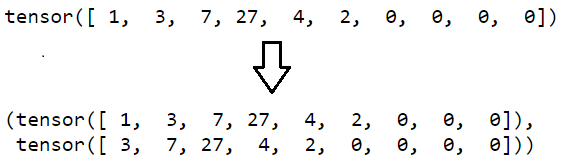

- [ ] Проверено на семинаре

In [ ]:
class PetsGenDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        names = self.dataframe.iloc[index]['имя']

        if isinstance(names, str):
            names = [names]
        else:
            names = names.tolist()

        tokens = list(map(lambda x: self.transform([i for i in x]), names))

        if len(tokens) == 1:
            return (tokens[0][:-1], tokens[0][1:])

        return list(map(lambda x: (x[:-1], x[1:]), tokens))

In [ ]:
transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(max_seq_len=8),
    T.AddToken(sos_idx, begin=True),
    T.AddToken(eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(max_length=10, pad_value=pad_idx),
)

petsdataset = PetsGenDataset(data, transform)

print(petsdataset[0], '\n')
print(petsdataset[:2])

[(tensor([ 2,  7, 25,  7, 28,  6, 18, 18,  7]), tensor([ 7, 25,  7, 28,  6, 18, 18,  7,  3]))] 

[(tensor([ 2,  7, 25,  7, 28,  6, 18, 18,  7]), tensor([ 7, 25,  7, 28,  6, 18, 18,  7,  3])), (tensor([ 2,  7, 25, 32, 15, 18, 18,  6, 19]), tensor([ 7, 25, 32, 15, 18, 18,  6, 19,  3]))]


In [ ]:
loader = DataLoader(petsdataset, batch_size=128, shuffle=True)

for x, y in loader:
  print(x.shape, y.shape)
  break

torch.Size([200, 9]) torch.Size([200, 9])


<p class="task" id="3"></p>

### 3
Напишите функцию, которая генерирует имя питомца при помощи обученной модели:
  * построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * начальное скрытое состояние RNN `h_t = None`;
  * в результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности;
  * функция возвращает строку из букв с первой заглавной буквой.
  
- [ ] Проверено на семинаре

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super().__init__()

        self.emb = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        emb = self.emb(x)
        out, h = self.rnn(emb)
        out = out.reshape(out.shape[0]*out.shape[1], out.shape[2])
        out = self.linear(out)
        return out

epoch=5, epoch_loss=26.251498222351074
epoch=10, epoch_loss=25.20685875415802
epoch=15, epoch_loss=24.54433524608612
epoch=20, epoch_loss=24.023458123207092
epoch=25, epoch_loss=23.700105786323547
epoch=30, epoch_loss=23.302077531814575


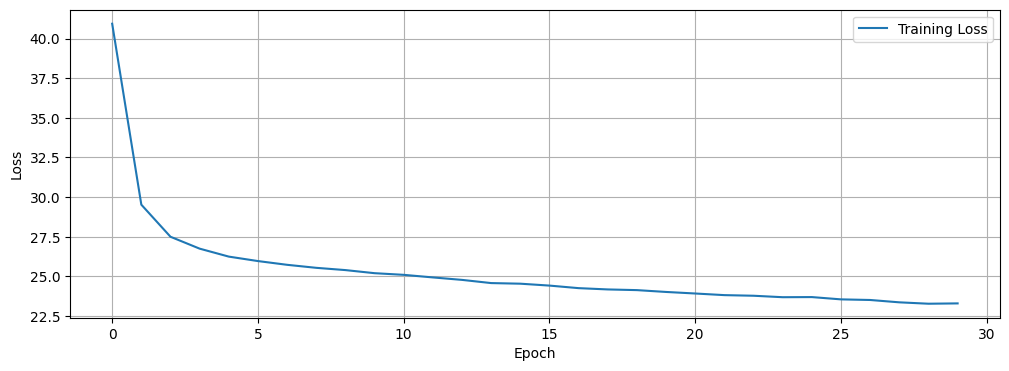

In [ ]:
num_epochs = 30

model = Net(input_size=len(vocab), embedding_size=100, hidden_size=50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses_list = []

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for x, y in loader:
        output = model(x)
        loss = criterion(output, y.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    train_losses_list.append(epoch_loss)

    if (epoch) % 5 == 0:
        print(f'{epoch=}, {epoch_loss=}')

plt.figure(figsize=(12, 4))
plt.plot(train_losses_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid();

In [ ]:
for x, y in loader:
    output = model(x)
    print(output.shape)
    print(y.view(-1).shape)
    break

torch.Size([1280, 66])
torch.Size([1280])


In [ ]:
def name_generator(model, max_length, vocab):

    name = [sos_idx]

    while True:
        input_tensor = torch.tensor([[name[-1]]])

        with torch.no_grad():
            out = model(input_tensor)

        probs = torch.softmax(out, dim=1)[0]
        next_token = torch.multinomial(probs, 1).item()

        if next_token not in [sos_idx, eos_idx, pad_idx] and len(name) < max_length:
            name.append(next_token)
        else:
            break

    generated_name = ''.join(vocab.lookup_tokens(name[1:])).capitalize()

    return generated_name

In [ ]:
for i in range(5):
    print(name_generator(model=model, max_length=10, vocab=vocab))

Bey
Gorinane
Шугоза
Pame
Линаририн


<p class="task" id="4"></p>

### 4
Создайте и обучите модель для генерации имени питомца. Задача классификации ставится как предсказание следующего токена в каждом примере из пакета для каждого элемента последовательности (по прочитанной подстроке предсказывается следующий символ для данной строки). Каждые несколько эпох выводите примеры генерации имен при помощи текущего состояния модели. Игнорируйте токен `<PAD>` при расчете ошибки.

Примерная схема реализации метода `forward`:
```
input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
```

- [ ] Проверено на семинаре

In [ ]:
num_epochs = 30

model = Net(input_size=len(vocab), embedding_size=100, hidden_size=50)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses_list = []

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for x, y in loader:
        output = model(x)
        loss = criterion(output, y.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    train_losses_list.append(epoch_loss)

    if (epoch) % 5 == 0:
        print(f'{epoch=} {name_generator(model=model, max_length=10, vocab=vocab)}')

epoch=5 Oderixich
epoch=10 Filidenwa
epoch=15 Mipevanan
epoch=20 Noy
epoch=25 Ка
epoch=30 Халинила


<p class="task" id="5"></p>

### 5
Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`, `<RU>`, `<EN>`. Выведите на экран количество токенов в полученном словаре.

Модифицируйте датасет `PetsGenDataset` таким образом, чтобы в начало каждого примера добавлялся токен `<RU>`, если это имя питомца на русском, и `<EN>`, если имя на английском. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

- [ ] Проверено на семинаре

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/pets_ru_en.csv")
data.head()

,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en


In [ ]:
data['имя'] = data['имя'].str.lower()
data = data.drop_duplicates(subset=['имя'])
data.shape

(2894, 2)

In [ ]:
vocab = build_vocab_from_iterator(data['имя'].tolist(), specials=['<UNK>', '<PAD>', '<SOS>', '<EOS>', '<RU>', '<EN>'])
vocab.set_default_index(0)

In [ ]:
len(vocab)

66

In [ ]:
# ИСПОЛЬЗУЕТСЯ В ДАЛЬНЕЙШЕМ, ОБРАТИТЕ ВНИМАНИЕ!!!
sos_idx = vocab.lookup_indices(['<SOS>'])[0]
eos_idx = vocab.lookup_indices(['<EOS>'])[0]
pad_idx = vocab.lookup_indices(['<PAD>'])[0]
ru_idx = vocab.lookup_indices(['<RU>'])[0]
en_idx = vocab.lookup_indices(['<EN>'])[0]

In [ ]:
class PetsGenDatasetV2(Dataset):
    def __init__(self, dataframe, ru_transform, en_transform):
        self.dataframe = dataframe
        self.ru_transform = ru_transform
        self.en_transform = en_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        names = self.dataframe.iloc[index]['имя']
        languages = self.dataframe.iloc[index]['язык']

        if isinstance(names, str):
            names = [names]
            languages = [languages]
        else:
            names = names.tolist()
            languages = languages.tolist()

        tokens_list = []
        for i in range(len(names)):
            if languages[i] == 'rus':
                tokens = self.ru_transform([token for token in names[i]])
            else:
                tokens = self.en_transform([token for token in names[i]])

            tokens_list.append((tokens[:-1], tokens[1:]))

        if len(tokens_list) == 1:
            return tokens_list[0]

        return tokens_list

In [ ]:
ru = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(max_seq_len=8),
    T.AddToken(ru_idx, begin=True),
    T.AddToken(sos_idx, begin=True),
    T.AddToken(eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(max_length=11, pad_value=pad_idx),
)

en = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(max_seq_len=8),
    T.AddToken(en_idx, begin=True),
    T.AddToken(sos_idx, begin=True),
    T.AddToken(eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(max_length=11, pad_value=pad_idx),
)

petsdataset = PetsGenDatasetV2(data, ru_transform=ru, en_transform=en)

print(petsdataset[0], '\n')
print(petsdataset[:2])

(tensor([ 2,  5,  9, 27,  9, 30,  8, 20, 20,  9]), tensor([ 5,  9, 27,  9, 30,  8, 20, 20,  9,  3])) 

[(tensor([ 2,  5,  9, 27,  9, 30,  8, 20, 20,  9]), tensor([ 5,  9, 27,  9, 30,  8, 20, 20,  9,  3])), (tensor([ 2,  5,  9, 27, 34, 17, 20, 20,  8, 21]), tensor([ 5,  9, 27, 34, 17, 20, 20,  8, 21,  3]))]


In [ ]:
loader = DataLoader(petsdataset, batch_size=128, shuffle=True)

for x, y in loader:
  print(x.shape, y.shape)
  break

torch.Size([128, 10]) torch.Size([128, 10])


<p class="task" id="6"></p>

### 6
Модифицируйте функцию для генерации имени, добавив возможность указать первый токен - `<RU>` или `<EN>`. Создайте и обучите модель для генерации имени питомца с указанием языка. Каждые несколько эпох выводите примеры генерации русскоязычных и англоязычных имен при помощи текущего состояния модели . Игнорируйте токен `<PAD>` при расчете ошибки.

- [ ] Проверено на семинаре


In [ ]:
def name_generator(model, max_length, vocab, language):

    name = [vocab.lookup_indices([language])[0]]

    while True:
        input_tensor = torch.tensor([[name[-1]]])

        with torch.no_grad():
            out = model(input_tensor)

        probs = torch.softmax(out, dim=1)[0]
        next_token = torch.multinomial(probs, 1).item()

        if next_token not in [sos_idx, eos_idx, pad_idx, en_idx, ru_idx] and len(name) < max_length:
            name.append(next_token)
        else:
            break

    generated_name = ''.join(vocab.lookup_tokens(name[1:])).capitalize()

    return generated_name

In [ ]:
num_epochs = 100

model = Net(input_size=len(vocab), embedding_size=500, hidden_size=50)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses_list = []

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for x, y in loader:
        output = model(x)
        loss = criterion(output, y.view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    train_losses_list.append(epoch_loss)

    if (epoch) % 10 == 0:
        print(f"{epoch=} {epoch_loss=} RU:{name_generator(model=model, max_length=10, vocab=vocab, language='<RU>')} EN:{name_generator(model=model, max_length=10, vocab=vocab, language='<EN>')}")

epoch=10 epoch_loss=49.29436802864075 RU:Чиязанр-л EN:Bi
epoch=20 epoch_loss=46.56514871120453 RU:Энy EN:A
epoch=30 epoch_loss=45.469998478889465 RU:Белька EN:Bo
epoch=40 epoch_loss=44.71468961238861 RU:Синнаша EN:Panaра
epoch=50 epoch_loss=44.11175334453583 RU:На EN:Motonidra
epoch=60 epoch_loss=43.592082500457764 RU:Херка EN:Ka
epoch=70 epoch_loss=43.141414403915405 RU:Мигга юга EN:Warorinod
epoch=80 epoch_loss=42.67272984981537 RU:Улелька EN:Pinittith
epoch=90 epoch_loss=42.3899062871933 RU:Жеся EN:Glaда
epoch=100 epoch_loss=42.04750990867615 RU:Фькани EN:Bakhe


## Обратная связь
- [x] Хочу получить обратную связь по решению